# E. coli Promoter Classification Naive Model

In this notebook we train a classification model using only the promoter dataset - no language model pretraining. This serves as a baseline to verify the effect of unsupervised pretraining.

This notebook also elaborates on how genomic data is process for the classification model. Many functions in the `utils.py` file are explained here.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

# sets device for model and PyTorch tensors
os.environ["CUDA_VISIBLE_DEVICES"]="0"
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7" # "-1" if want to run on a CPU, otherwise define the GPU number

In [3]:
#from fastai import *
from fastai.text import ( BaseTokenizer, Tokenizer, Vocab, 
                         PreProcessor, ItemList, PathOrStr, 
                         DataFrame, Optional, Collection, 
                         IntsOrStrs, DataBunch, is_listy, 
                         ItemLists, TextList, SortishSampler, 
                         DataLoader, SortSampler, partial, pad_collate )

import sys
from pathlib import Path

import pandas as pd
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [4]:
sys.path.append("../..")
from utils import _get_genomic_processor, get_model_clas, TextClasDataBunch, get_scores

In [5]:
path = Path('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/data/genomic_ulmfit/ecoli/')

In [6]:
classification_df = pd.read_csv(path/'e_coli_promoters_dataset.csv')

The only input to the model will be sequence data from -150/50 from defined TSS locations.

In [7]:
classification_df.head()

,Gene,Locus,Location,Sample Location,Orientation,Sequence,Promoter,Independent,set
0,['yaaX'],['b0005'],[5233:5530](+),[5133:5283](+),forward,GTAACTTAGAGATTAGGATTGCGGAGAATAACAACCGCCGTTCTCA...,1,False,train
1,['talB'],['b0008'],[8237:9191](+),[8137:8287](+),forward,ATAACCGTCTTGTCGGCGGTTGCGCTGACGTTGCGTCGTGATATCA...,1,False,train
2,['yaaW'],['b0011'],[10642:11356](-),[11306:11456](-),reverse,TCAAAAATCACCTTTTCGGGTCATACGGTGAACTCATCGGATATGG...,1,False,train
3,['hokC'],['b4412'],[16750:16903](-),[16853:17003](-),reverse,AAAGCCCCGAGTGATATTTTACCATCAACCCGAGGCCTCCTATATG...,1,False,train
4,['nhaA'],['b0019'],[17488:18655](+),[17388:17538](+),forward,TAAAAAACGAATTATTCCTACACTATAATCTGATTTTAACGATGAT...,1,False,train


In [8]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [9]:
train_df.shape, valid_df.shape, test_df.shape

((6791, 9), (750, 9), (830, 9))

# Tokenization and Numericalization

Before feeding genomic sequence data to the model, it needs to be processed into tokens. For this, we use the `GenomicTokenizer` class. This subclasses the `BaseTokenizer` class in the fastai library.The genomic sequences are tokenized by breaking the sequence into k-mers. The k-mer tokenization is defined by two parameters - `ngram` and `stride`. `ngram` determines the length of the k-mers. `stride` defines how far the k-mer window moves between k-mers. Empirically I have found that a k-mer size of 5 with a stride of 2 works well. This creates a list of sequential tokens with 3bp of overlap between each token.

In [10]:
class GenomicTokenizer(BaseTokenizer):
    def __init__(self, lang='en', ngram=5, stride=2):
        self.lang = lang
        self.ngram = ngram
        self.stride = stride
        
    def tokenizer(self, t):
        t = t.upper()
        if self.ngram == 1:
            toks = list(t)
        else:
            toks = [t[i:i+self.ngram] for i in range(0, len(t), self.stride) if len(t[i:i+self.ngram]) == self.ngram]
        if len(toks[-1]) < self.ngram:
            toks = toks[:-1]
        
        return toks
    
    def add_special_cases(self, toks):
        pass

The tokenization function is passed to the fastai `Tokenizer` class

In [11]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

Once tokens are created, they are numericalized with the `GenomicVocab` class. This class holds two objects: `itos`, a list of each k-mer in the model's vocabulary, and `stoi`, a dictionary that maps each k-mer to its index in the `itos` list. This creates the k-mer to number mapping that we will use to numericalize our data. When we tokenize the sequences into 5bp tokens, we create a vocabulary of 1024 (4^5) tokens.  We also insert a padding token that will allow us to deal with sequences of different length.

In [12]:
class GenomicVocab(Vocab):
    def __init__(self, itos):
        self.itos = itos
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})
        
    @classmethod
    def create(cls, tokens, max_vocab, min_freq):
        freq = Counter(p for o in tokens for p in o)
        itos = [o for o,c in freq.most_common(max_vocab) if c >= min_freq]
        itos.insert(0, 'pad')
        return cls(itos)

Tokenizing and numericalizing are handled by the `PreProcessor` class. Specifically we have the `GenomicTokenizeProcessor` for tokenization and the `GenomicNumericalizeProcessor` for numericalization.

In [13]:
class GenomicTokenizeProcessor(PreProcessor):
    "`PreProcessor` that tokenizes the texts in `ds`."
    def __init__(self, ds:ItemList=None, tokenizer:Tokenizer=None, chunksize:int=10000, mark_fields:bool=False):
        self.tokenizer,self.chunksize,self.mark_fields = ifnone(tokenizer, Tokenizer()),chunksize,mark_fields

    def process_one(self, item):  
        return self.tokenizer._process_all_1(_genomic_join_texts([item], self.mark_fields))[0]
    
    def process(self, ds):
        ds.items = _genomic_join_texts(ds.items, self.mark_fields)
        tokens = []
        for i in range(0,len(ds),self.chunksize):
            tokens += self.tokenizer.process_all(ds.items[i:i+self.chunksize])
        ds.items = tokens
        
class GenomicNumericalizeProcessor(PreProcessor):
    "`PreProcessor` that numericalizes the tokens in `ds`."
    def __init__(self, ds:ItemList=None, vocab:Vocab=None, max_vocab:int=60000, min_freq:int=3):
        vocab = ifnone(vocab, ds.vocab if ds is not None else None)
        self.vocab,self.max_vocab,self.min_freq = vocab,max_vocab,min_freq

    def process_one(self,item): return np.array(self.vocab.numericalize(item), dtype=np.int64)
    def process(self, ds):
        if self.vocab is None: self.vocab = GenomicVocab.create(ds.items, self.max_vocab, self.min_freq)
        ds.vocab = self.vocab
        super().process(ds)

Using these functions to process the input dataframe is handled by the `GenomicTextClasDataBunch` class. This takes as input the training data, the tokenizer, and a vocabulary if one is predefined.

In [14]:
class GenomicTextClasDataBunch(TextClasDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, chunksize:int=10000, max_vocab:int=60000,
                min_freq:int=2, mark_fields:bool=False, pad_idx=0, pad_first=True, bs=64, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames. `kwargs` are passed to the dataloader creation."
        processor = _get_genomic_processor(tokenizer=tokenizer, vocab=vocab, chunksize=chunksize, max_vocab=max_vocab,
                                   min_freq=min_freq, mark_fields=mark_fields)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_from_df(cols=label_cols, classes=classes, label_delim=label_delim)
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        d1 = src.databunch(**kwargs)
        
        datasets = cls._init_ds(d1.train_ds, d1.valid_ds, d1.test_ds)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=False)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=bs, sampler=sampler, **kwargs))
            
        return cls(*dataloaders, path=path, collate_fn=collate_fn)

In [15]:
batch_size = 300 # 300
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, test_df=test_df, tokenizer=tok, 
                                            text_cols='Sequence', label_cols='Promoter', bs=batch_size)

# Data Processing

As discussed, the genomic sequences for the promoters are split into 5-mers with a stride of 2. Here we can see the raw tokens and their numericalized form.

In [16]:
data_clas.train_ds[0]

(Text [ 649  584  995 1006 ...  683  102   15  522], Category 1)

These are the integers associated with each k-mer. When these integers are fed to the model, they map to specific rows of the embedding matrix. The embedding contains vector representations of each k-mer.

In [17]:
data_clas.train_ds[0][0].data

array([ 649,  584,  995, 1006, ...,  683,  102,   15,  522])

# Classification Model

The model used is based on the [AWD-LSTM](https://arxiv.org/abs/1708.02182) model. The model consists of an embedding layer, followed by a stack of LSTM layers, followed by several linear layers. The configuration I typically use is defined by the `clas_config` dictionary below. 

The embedding vectors are of length 400. The LSTM section consists of three stacked layers with a hidden size of 1150 units. The final linear section is defined by the `PoolingLinearClassifier` class in the fastai library. The output from the LSTM layers contain each hidden state from each k-mer. The linear section takes the final hidden state, as well as the max pooling vector over the hidden states and the average pooling vector over the hidden states. These three vectors are concatenated together and sent through two standard linear layers. The output is a vector of length 2, representing probabilities of the input being a promoter or not a promoter.

Regularization is applied to the model following the implementation in the AWD-LSTM paper.

In [18]:
embedding_size = 400 #400
n_hid = 1150 # 1150
n_layers = 3 # 3
clas_config = dict(emb_sz=embedding_size, n_hid=n_hid, n_layers=n_layers, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.2

In [19]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [ ]:
#encoder, model = get_model_clas(data_clas, drop_mult, clas_config)
#import numpy as np
#total_params = 0
#for p in model.parameters():
#    total_params += np.prod(p.shape)
#print(total_params)

In [20]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1025, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(1025, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.08000000000000002, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): Ba

The model is trained for several epochs following the learning rate and momentum scheduling outlined in [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, momentum, and weight decay](https://arxiv.org/abs/1803.09820)

In [21]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


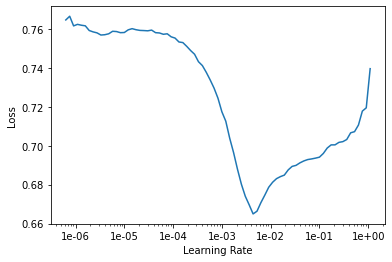

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(5, 2e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.620922,0.670213,0.534667,00:31
1,0.471915,1.110669,0.500000,00:31
2,0.393251,0.582682,0.685333,00:31
3,0.339665,0.342361,0.857333,00:31
4,0.290879,0.321618,0.872000,00:31


In [24]:
learn.fit_one_cycle(5, 5e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.203070,0.320307,0.869333,00:31
1,0.209858,0.427924,0.820000,00:31
2,0.224953,0.486995,0.821333,00:31
3,0.214847,0.350331,0.852000,00:31
4,0.196643,0.357235,0.857333,00:31


In [25]:
learn.fit_one_cycle(5, 1e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.162312,0.365426,0.860000,00:31
1,0.160846,0.454316,0.833333,00:31
2,0.158306,0.377024,0.856000,00:31
3,0.151137,0.383112,0.864000,00:31
4,0.144733,0.390011,0.864000,00:31


In [26]:
learn.save('coli_naive', return_path=True)

PosixPath('/mnt/wd_4tb/shared_disk_wd4tb/mattscicluna/data/genomic_ulmfit/ecoli/models/coli_naive.pth')

# Test

Testing the trained model on the test set

In [27]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, 
                                            text_cols='Sequence', label_cols='Promoter', bs=300)
learn.data = data_clas

In [28]:
get_scores(learn)

Accuracy: 0.8686746987951808
False Positives: 0.06144578313253012
False Negatives: 0.06987951807228916
Recall: 0.8602409638554217
Precision: 0.875
Specificity: 0.8771084337349397
MCC: 0.7374543121843155


The model achieves good accuracy, precision, and recall, but can be extremely unstable. Observe how the accuracy can fluctuate sharply between epochs. Several runs were needed to get the results above. Bad initializations result in the model never actually training. In the next notebook, we will see how pretraining can significantly stabilize the model.